In [44]:
import pandas as pd

def read_data(full = True):
    LOG_PATH = "event_log.csv" if not full else "event_log_full.csv"     # adapt if needed
    df = pd.read_csv(LOG_PATH, parse_dates=["start_time", "completion_time"])
    df['patient_id'] = df['case_id']
    return df


# Basic clean-ups
def data_preprocessing(df):
    df["duration_sec"] = (df["completion_time"] - df["start_time"]).dt.total_seconds()
    df.sort_values(["case_id", "start_time"], inplace=True)

    # ↓ pm4py expects the following column names
    df.rename(columns={
        "case_id": "case:concept:name",
        "event_label": "concept:name",
        "start_time": "time:timestamp"
    }, inplace=True)
    return df
    
def create_full_event_log():
    df = read_data()
    # Create a mapping from case_id to diagnosis (excluding None)
    filtered_df = df[df["event_label"].isin(["emergency_patient", "patient_referal"])]
    case_diag_map = {}
    for case_id, diagnosis in zip(filtered_df["case_id"], filtered_df["diagnosis"]):
        if diagnosis is not None:
            case_diag_map[case_id] = diagnosis
    print(case_diag_map)
    # Fill the diagnosis column for each row using the mapping
    df["diagnosis"] = df["case_id"].map(case_diag_map).combine_first(df["diagnosis"])
    df.to_csv("event_log_full.csv", index=False)


In [3]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

def process_mining(df):
    df = data_preprocessing(df)
    event_log = log_converter.apply(df)

    # Inductive Miner – robust for real logs
    tree = pm4py.discover_process_tree_inductive(event_log)
    bpmn_graph = pm4py.convert_to_bpmn(tree)
    pm4py.view_bpmn(bpmn_graph)   # shows an interactive BPMN diagram

    # If you prefer a Petri net:
    net, im, fm = pm4py.discover_petri_net_inductive(event_log)
    pm4py.view_petri_net(net, im, fm)

In [30]:
def get_patient_with_diagnosis(df, diagnosis):
    # Find all unique case_ids where diagnosis matches
    if diagnosis is None:
        filtered_df = df[df["event_label"].isin(["emergency_patient", "patient_referal"])]
        allowed_diagnoses = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
        filtered_df = filtered_df[~filtered_df["diagnosis"].isin(allowed_diagnoses)]
        case_ids = filtered_df["case_id"].unique()
    else:
        case_ids = df.loc[df["diagnosis"] == diagnosis, "case_id"].unique()
    # Select all rows with those case_ids
    return filtered_df[filtered_df["case_id"].isin(case_ids)]


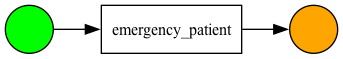

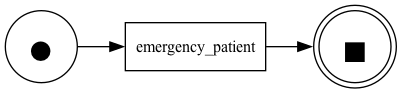

In [32]:

df = read_data()
cur_df = get_patient_with_diagnosis(df, None)
process_mining(cur_df)
# cur_df

In [15]:
df = read_data()
diagnosis_counts = df["diagnosis"].value_counts(normalize=True, dropna=False) * 100
print("Percentage of each diagnosis (including None):")
print(diagnosis_counts)


Percentage of each diagnosis (including None):
diagnosis
NaN    81.748973
B1      5.849945
A1      3.185415
B2      2.914955
A2      1.612742
B4      1.492537
B3      1.492537
A4      0.881499
A3      0.821396
Name: proportion, dtype: float64


In [20]:
df = read_data()
# Filter for emergency_patient and patient_referal events
filtered_df = df[df["event_label"].isin(["emergency_patient", "patient_referal"])]

# Find case_ids that appear more than once in filtered_df
duplicate_case_ids = filtered_df["case_id"].value_counts()
duplicate_case_ids = duplicate_case_ids[duplicate_case_ids > 1].index.tolist()

if duplicate_case_ids:
    print("case_id(s) with multiple rows in filtered_df:")
    print(duplicate_case_ids)
    print(filtered_df[filtered_df["case_id"].isin(duplicate_case_ids)])
else:
    print("No case_id with multiple rows in filtered_df.")


No case_id with multiple rows in filtered_df.


In [49]:

event_labels_of_interest = ["surgery", "nursing", "intake", "ER_treatment"]
df = read_data()
df = df[df["diagnosis"].notna()]
# print(df)
for event_label in event_labels_of_interest:
    print(f"\nEvent label: {event_label}")
    event_df = df[df["event_label"] == event_label]
    # print(event_df)
    diagnoses = event_df["diagnosis"].dropna().unique()
    # print(diagnoses)
    # Create a pivot table: rows = diagnosis, columns = resource, values = percentage of events
    if not event_df.empty:
        pivot_df = (
            event_df
            .groupby(["diagnosis", "resource"])
            .size()
            .unstack(fill_value=0)
        )
        # Convert counts to percentages per diagnosis
        pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
        # Order columns alphabetically
        pivot_df = pivot_df.reindex(sorted(pivot_df.columns, key=lambda x: (str(x))), axis=1)
        print(f"\nResource distribution for event_label '{event_label}':")
        print(pivot_df.round(2))
        
        # Save the pivot table to a CSV file for each event_label
        csv_filename = f"resource_distribution_{event_label}.csv"
        pivot_df.to_csv(csv_filename)
        print(f"Saved resource distribution for '{event_label}' to {csv_filename}")

    else:
        print(f"No data for event_label '{event_label}'.")



Event label: surgery

Resource distribution for event_label 'surgery':
resource     OR1    OR2    OR3    OR4    OR5
diagnosis                                   
A2         14.19  19.35  21.94  21.94  22.58
A3         30.12  24.10  14.46  13.25  18.07
A4         21.11  17.78  23.33  13.33  24.44
B3         19.01  31.69  19.01  11.97  18.31
B4         15.44  30.87  17.45   9.40  26.85
Saved resource distribution for 'surgery' to resource_distribution_surgery.csv

Event label: nursing

Resource distribution for event_label 'nursing':
resource   A_BED1  A_BED10  A_BED11  A_BED12  A_BED13  A_BED14  A_BED15  \
diagnosis                                                                 
A1           4.53     2.27     4.53     2.59     1.94     3.24     2.59   
A2           3.27     3.92     2.61     3.27     3.92     1.96     0.65   
A3           1.33     6.67     4.00     9.33     2.67     4.00     2.67   
A4           4.76     4.76     3.57     1.19     3.57     1.19     4.76   
B1          